# 201601615 이의찬

# 1. 지정 주제

## 영화: 외계+인 1부

먼저 기술적인 이유는 '외계+인 1부'가 사람들의 호불호가 갈리고 의견의 대립이 첨예하기 때문이다. <br>
원래 선정한 인생영화는 인터스텔라와 위플래쉬였으나 인터스텔라는 평이 너무 좋고 평점이 낮은 리뷰에는 댓글이 잘 달리지 않아서 극적인 결과를 확인하기 힘들었고 위플래쉬는 일반적인 '재미없다'라는 평보다 광기, 싸이코패스 등 일반적이지 않은 평이 많아서 분류기 학습시킨 결과가 아쉬웠기 때문에 좋은 평가와 안 좋은 평가가 골고루 있는 영화 '외계+인 1부'를 선정하게 되었다. 

개인적인 이유는 최근에 'her'라는 영화를 보고 머리를 비우고 싶어서 본 영화이다. 영화를 보기 전에 기대를 하지 않고 봤었고 한국 영화에 드문 참신한 컨셉이 재밌었고 딱 떨이지는 스토리도 좋았다. 인생영화라고 하기엔 2부까지 나와봐야 알겠지만 최근에 재밌게 봐서 선정해 보았다.

In [38]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By # find_element 를 할 때, 속성값 관리
from selenium.webdriver.common.keys import Keys
from urllib.request import urlopen
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter
from konlpy.tag import Okt
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import urllib
import time

okt = Okt()

POS = 9
NEG = 4

In [2]:
driver_path = "chromedriver.exe" # 경로명: 현재 폴더로 되어있음
movie_url = r"https://movie.daum.net/moviedb/grade?movieId=139606"

### selenium 드라이버

In [3]:
driver = webdriver.Chrome(driver_path)
driver.implicitly_wait(3) # 열리는 시간 3초 대기
driver.get(movie_url)

C:\Users\outda\AppData\Local\Temp\ipykernel_2596\3252897723.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(driver_path)


## 1. 영화 리뷰 가져오기

#### 함수

In [4]:
def load_all_reviews(driver:webdriver):
    # 평점을 남긴 유저 수(페이지 버튼 누를 횟수 계산할 때 사용)
    user_count = driver.find_element(
        By.CLASS_NAME, "txt_netizen"
    ).text.strip("()명") 

    # more 버튼 누르는 총 횟수
    more_count = (int(user_count) - 10) // 30 + 1 

    # 더보기 버튼
    more_button = '//*[@id="alex-area"]/div/div/div/div[3]/div[1]/button' 
    
    # 더보기 버튼 클릭
    for i in tqdm(range(more_count)):
        driver.find_element("xpath", more_button).click()
        time.sleep(2)
        
def is_browser_alive(driver:webdriver):
    # 브라우저가 켜져있는지 확인 하는 함수
    try:
        driver.current_url
        return True
    except:
        return False

In [7]:
load_all_reviews(driver)

  0%|          | 0/53 [00:00<?, ?it/s]

In [8]:
# html 텍스트 파일 저장 코드
html = driver.page_source
text_file = open('inter_review_data.txt', 'w', encoding='utf-8')
text_file.write(html)
text_file.close()

In [9]:
# selenium으로 작업한 url 정보를 html로 가져옴
# html = driver.page_source

with open('inter_review_data.txt', 'r', encoding='utf-8') as f:
    html = f.read()
    f.close()

soup = BeautifulSoup(html, "html.parser")

div_reviews = soup.find_all("div", {"class": "cmt_info"})

# 유저 댓글 평점
# list<<tuple(댓글:str, 평점:int)>>
reviews = []

for review in tqdm(div_reviews):
    comment = review.find("p", {"class": "desc_txt font_size_"}) # 댓글
    
    if not comment:
        # 댓글을 적지 않고 평점만 줬다면 무시
        continue
        
    comment = comment.text.strip() # 댓글
    rating = int(review.find("div").text) # 평점: 첫번째 div
    
    reviews.append((comment, rating))

  0%|          | 0/1576 [00:00<?, ?it/s]

#### driver.page_source 사용 이유

```python
html = urlopen(movie_url)
soup = BeautifulSoup(html.read(), "html.parser")
```

`driver.page_source`를 사용하여 현재 `selenium`으로 렌더링 된 페이지의 모든 `Elements`를 모두 가져오고 selenium으로 작업한 url 정보를 html로 가져온다.

## 2. 워드 클라우드 그리기

#### 함수

In [10]:
# from konlpy.tag import Okt
# from collections import Counter
# from wordcloud import WordCloud

# okt = Okt()

def okt_pos_by_filter(text:str, filter=['Noun', 'Verb', 'Adjective']):
    '''
    okt를 이용해서 문장을 단어로
    분리하고 필터링(기본값: 명사, 동사, 형용사)하는 함수
    '''
    result = []
    for t in okt.pos(text, norm=True, stem=True):
        if t[1] in filter:
            result.append(t[0])
            
    return result

def remove_meaningless_words(words):
    '''의미없는 단어 삭제하는 함수'''
    # 한 글자로 이루어진 단어 제거
    stopword_list = []
    
    for word in words:
        if len(word) == 1:
            stopword_list.append(word)

    for stopword in stopword_list:
        words.pop(stopword)

    # 의미없는 동사 제거
    verbs = [
        '하다', '보다', '있다', '되다', '이다', 
        '이렇다', '그렇다', '이겠다'
    ]
    
    for v in verbs:
        if v in words:
            words.pop(v)
    
    return words

def generate_wc_frequencies(word_count):
    '''워드 클라우드 빈도수 객체 생성'''
    wc = WordCloud(
        background_color='white', 
        max_words=5000, 
        font_path=r'C:\Windows\Fonts\gulim.ttc', 
        colormap='seismic'
    )
    return wc.generate_from_frequencies(word_count)

### 2-1. 전체, 긍정, 부정 평가 단어 처리하기

전체: `all_comment_words`, `all_comments_word_count`

긍정: `pos_comment_words`, `pos_comment_word_count`

부정: `neg_comment_words`, `neg_comment_word_count`

In [11]:
# 댓글의 명사, 동사, 형용사만 추출
all_comment_words = []
pos_comment_words = []
neg_comment_words = []

for review in tqdm(reviews):
    comment = review[0].replace("\n", " ")
    rating = review[1]
    
    all_comment_words += okt_pos_by_filter(comment)
    if rating >= POS: 
        pos_comment_words += okt_pos_by_filter(comment)
        
    elif rating <= NEG: 
        neg_comment_words += okt_pos_by_filter(comment)
        
all_comment_word_count = Counter(all_comment_words)
all_comment_word_count = remove_meaningless_words(all_comment_word_count)

pos_comment_word_count = Counter(pos_comment_words)
pos_comment_word_count = remove_meaningless_words(pos_comment_word_count)

neg_comment_word_count = Counter(neg_comment_words)
neg_comment_word_count = remove_meaningless_words(neg_comment_word_count)    

  0%|          | 0/1563 [00:00<?, ?it/s]

### 2-3. 워드 클라우드

#### 2-3-1. 전체

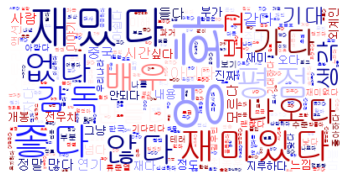

In [12]:
all_wc = generate_wc_frequencies(all_comment_word_count)
plt.imshow(all_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-2. 전체 결과 해석

전체적으로 재미있다, 좋다라는 평이 많고 타짜, 감독이라는 글자가 큰 이유는 타짜, 도둑들 같은 흥행 작품을 했던 유명한 감독이라서 '감독'이라는 키워드가 자주 언급된 것으로 보인다. 

#### 2-3-3. 긍정 리뷰 워드 클라우드

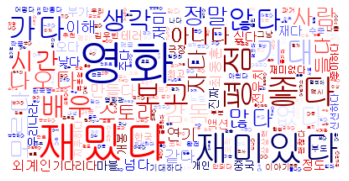

In [13]:
pos_wc = generate_wc_frequencies(pos_comment_word_count)
plt.imshow(pos_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-4. 부정 리뷰 워드 클라우드

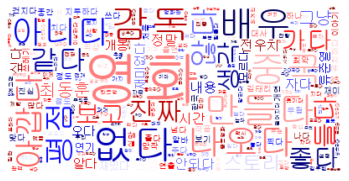

In [14]:
neg_wc = generate_wc_frequencies(neg_comment_word_count)
plt.imshow(neg_wc, interpolation="bilinear")
plt.axis('off') # 테두리 제거
plt.show()

#### 2-3-4. 긍정 리뷰, 부정 리뷰 결과 해석, 비교

## 3. 분류기 학습시키기

#### 함수

In [15]:
def load_data(file_path):
    train = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.strip()
            id, doc, label = line.split('\t')
            if label == '1': 
                label = 'pos'
            elif label == '0': 
                label = 'neg'
            train.append((doc, label))
    return train

def format_data(reviews):
    train = []
    
    for review in reviews:
        comment = review[0].replace("\n", " ")
        if len(comment) > 140:
            continue
            
        rating = review[1]
        
        if rating >= POS:
            label = 'pos'
        elif rating <= NEG:
            label = 'neg'
        else:
            continue
        
        train.append((comment, label))
        
    return train

def pos_tokenize(raw_sent):
    pos_sent = []
    sent = okt.pos(raw_sent, norm=True, stem=True)
    for tup in sent:
        word, tag = tup[0], tup[1]
        word_tag = word + '/' + tag
        pos_sent.append(word_tag)
    return ' '.join(pos_sent)

def make_word_dict(train, use_morph=False):
    all_words = set()
    
    for tup in tqdm(train):
        sent, label = tup[0], tup[1]
        if use_morph:
            sent = pos_tokenize(sent)
        words = word_tokenize(sent)
        for word in words:
            all_words.add(word)
    return all_words

def make_train_feats(train, all_words, use_morph=False):
    train_features = []
    
    for tup in tqdm(train):
        sent, label = tup[0], tup[1]
        if use_morph:
            sent = pos_tokenize(sent)
        words = word_tokenize(sent)
        tmp = {set_word: (set_word in words) for set_word in all_words}
        sent_tup = (tmp, label)
        train_features.append(sent_tup)
    return train_features

In [16]:
train = format_data(reviews)

In [17]:
use_morph = True
all_words = make_word_dict(train, use_morph)
train_feature = make_train_feats(train, all_words, use_morph)

  0%|          | 0/1117 [00:00<?, ?it/s]

  0%|          | 0/1117 [00:00<?, ?it/s]

In [18]:
classifier = nltk.NaiveBayesClassifier.train(train_feature)
classifier.show_most_informative_features()

Most Informative Features
          재미있다/Adjective = True              pos : neg    =     31.2 : 1.0
                 졸다/Verb = True              neg : pos    =     15.1 : 1.0
                 재다/Verb = True              pos : neg    =     15.1 : 1.0
           재밌다/Adjective = True              pos : neg    =     14.9 : 1.0
                 점도/Noun = True              neg : pos    =     12.5 : 1.0
                 부가/Noun = True              pos : neg    =     11.0 : 1.0
            낮다/Adjective = True              pos : neg    =     10.3 : 1.0
                 중간/Noun = True              neg : pos    =      9.8 : 1.0
                  해/Noun = True              neg : pos    =      9.8 : 1.0
           아깝다/Adjective = True              neg : pos    =      9.1 : 1.0


In [19]:
sents = load_data('ratings_test.txt')

count = 2000
matches_count = 0

for i in tqdm(range(1, count)):
    test_sent = sents[i][0]
    comment = test_sent
    test_sent = pos_tokenize(test_sent)
    words = word_tokenize(test_sent)
    test_feature = {set_word: (set_word in words) for set_word in all_words}
    
    if sents[i][1] == classifier.classify(test_feature):
        matches_count += 1
        
print('일치하는 비율: ', (matches_count/count)*100)

  0%|          | 0/1999 [00:00<?, ?it/s]

일치하는 비율:  67.75


In [19]:
test_sent = "졸다가 나왔음"
test_sent = pos_tokenize(test_sent)
words = word_tokenize(test_sent)
test_feature = {set_word: (set_word in words) for set_word in all_words}
print(classifier.classify(test_feature))

neg


In [20]:
nltk.classify.accuracy(classifier, train_feature)

0.9650850492390332

## 4. 지정 주제 느낀 점 및 자기 평가

# 자유주제

1. 내가 본 영화를 재밌게 본 사람의 다른 재밌는 영화
2. 다른 사이트와 비교
3. 중간 평점 추가
4. 댓글 알바 거르기?
5. 평점 남긴 사람의 이 영화 평점 백분위

In [32]:
if not is_browser_alive(driver):
    driver = webdriver.Chrome(driver_path)
    driver.implicitly_wait(3) # 열리는 시간 3초 대기
    driver.get(movie_url)
    time.sleep(2)
    load_all_reviews(driver)
    html = driver.page_source
    soup = BeautifulSoup(html, "html.parser")

C:\Users\outda\AppData\Local\Temp\ipykernel_2596\847372156.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(driver_path)


  0%|          | 0/53 [00:00<?, ?it/s]

In [39]:
# user_nickname_button = driver.find_elements(By.CSS_SELECTOR, 'a.link_nick')
# user_nickname_button[0].click()

a_nickname_buttons = soup.find_all("a", {"class": "link_nick"})
for nickname_button in a_nickname_buttons:
    user_id = nickname_button['data-reactid'].split('$')[1][:9]
    driver.find_element('xpath', f'//*[@id="comment{user_id}"]/div/strong/span/a/span[2]').send_keys(Keys.ENTER)
    time.sleep(2)
    close_button = driver.find_element('xpath', '//*[@id="alex-area"]/div/div/div[2]/div[2]/div[1]/a')
    time.sleep(2)


ElementNotInteractableException: Message: element not interactable
  (Session info: chrome=108.0.5359.99)
Stacktrace:
Backtrace:
	Ordinal0 [0x00F0ACD3+2075859]
	Ordinal0 [0x00E9EE61+1633889]
	Ordinal0 [0x00D9B680+571008]
	Ordinal0 [0x00DC647E+746622]
	Ordinal0 [0x00DC5B5A+744282]
	Ordinal0 [0x00DE731C+881436]
	Ordinal0 [0x00DC15BF+726463]
	Ordinal0 [0x00DE7534+881972]
	Ordinal0 [0x00DFB56A+963946]
	Ordinal0 [0x00DE7136+880950]
	Ordinal0 [0x00DBFEFD+720637]
	Ordinal0 [0x00DC0F3F+724799]
	GetHandleVerifier [0x011BEED2+2769538]
	GetHandleVerifier [0x011B0D95+2711877]
	GetHandleVerifier [0x00F9A03A+521194]
	GetHandleVerifier [0x00F98DA0+516432]
	Ordinal0 [0x00EA682C+1665068]
	Ordinal0 [0x00EAB128+1683752]
	Ordinal0 [0x00EAB215+1683989]
	Ordinal0 [0x00EB6484+1729668]
	BaseThreadInitThunk [0x76597BA9+25]
	RtlInitializeExceptionChain [0x7745BB9B+107]
	RtlClearBits [0x7745BB1F+191]
